In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from matplotlib import gridspec
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from scipy.signal import find_peaks, peak_prominences, peak_widths
from scipy import integrate


In [2]:
def read_DAT_file(name):
    with open(name) as pdbfile:
        q = []
        I = []
        dI = []
        start = 10000
        for i,line in enumerate(pdbfile):
            if 'q(A-1)' in line:
                start = i
            if i > start: 
                splitted_line = [line[0:20], line[23:50], line[50:]]
                q.append(splitted_line[0])
                I.append(splitted_line[1])
                dI.append(splitted_line[2])
        q = np.array([float(i) for i in q])
        I = np.array([float(i) for i in I])
        dI = np.array([float(i) for i in dI])
        data = np.hstack((q.reshape(-1,1), I.reshape(-1,1), dI.reshape(-1,1)))
    return data

In [4]:
#Load data for bilayer 
path = '../Data/SAXS/Kinetics/ESAXS_Sub/'
filenames = os.listdir(path)

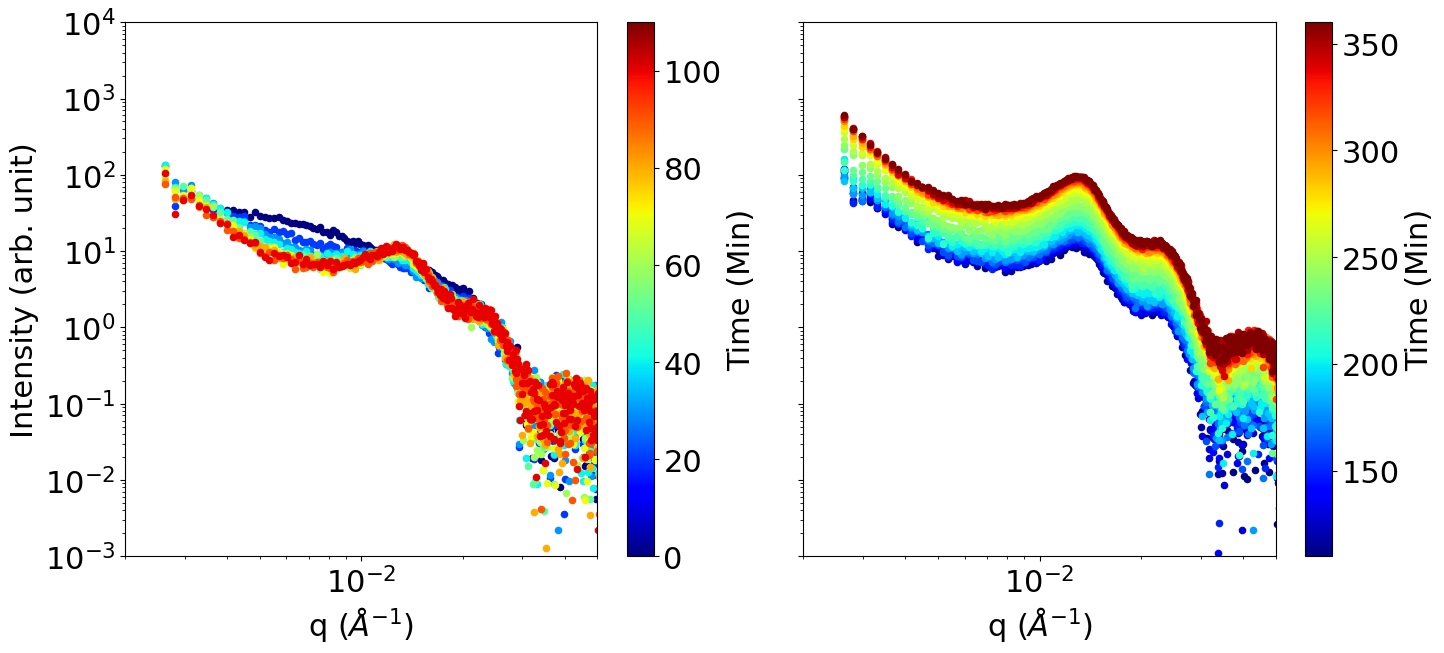

In [ ]:
plt.rcParams.update({'font.size': 22})

times = np.linspace(0, 360, 37)
times = np.delete(times, 1)


# Normalize times for colormap
norm = colors.Normalize(vmin=np.min(times), vmax=times[10])
cmap = cm.jet
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
# Plotting
fig, ax = plt.subplots(figsize=(15, 7), ncols=2)

for i in range(0, 10):
    data = read_DAT_file(path + filenames[i])
    if i == 0:
        ax[0].scatter(data[5:,0], data[5:,1], color=sm.to_rgba(times[i]), s = 20)
    else:
        ax[0].scatter(data[10:,0], data[10:,1], color=sm.to_rgba(times[i]), s = 20)


ax[0].set_xlabel('q ($\\AA$$^{-1}$)')
ax[0].set_ylabel('Intensity (arb. unit)')
ax[0].set_yscale('log')
ax[0].set_xscale('log')
#ax.grid(True, which='both', ls='--', lw=0.5)

# Add vertical colorbar
cbar = fig.colorbar(sm, ax=ax[0], orientation='vertical')
cbar.set_label('Time (Min)')


# Normalize times for colormap
norm = colors.Normalize(vmin=times[10], vmax=np.max(times))
cmap = cm.jet
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
# Plotting
for i in range(10, len(filenames)):
    data = read_DAT_file(path + filenames[i])
    ax[1].scatter(data[10:,0], data[10:,1], color=sm.to_rgba(times[i]), s = 20)

ax[1].set_xlabel('q ($\\AA$$^{-1}$)')
#ax[1].set_ylabel('Intensity (a.u.)')
ax[1].set_yticks([])
ax[1].set_yscale('log')
ax[1].set_xscale('log')
#ax.grid(True, which='both', ls='--', lw=0.5)
ax[1].set_yticklabels([])
ax[1].set_xlim([0.002, 0.05])
ax[1].set_ylim([1e-3, 1e4])
ax[0].set_xlim([0.002, 0.05])
ax[0].set_ylim([1e-3, 1e4])
# Add vertical colorbar
cbar = fig.colorbar(sm, ax=ax[1], orientation='vertical')
cbar.set_label('Time (Min)')
plt.tight_layout()
#plt.savefig('../Figures/Kinetics_Experiment.png', dpi=600, bbox_inches="tight")
plt.show()

In [7]:
def power_law_slope(data_2d):
    """
    Fit a power-law to 2D data and return the slope.
    
    Parameters:
        data_2d (np.ndarray): A 2D array with shape (n, 2), where each row is [x, y].

    Returns:
        slope (float): The power-law slope of the data.
        intercept (float): The y-intercept of the log-log fit.
    """
    data = np.array(data_2d)
    x = data[:, 0]
    y = data[:, 1]

    # Filter out non-positive values (log is undefined for them)
    mask = (x > 0) & (y > 0)
    x = x[mask]
    y = y[mask]

    # Take logs
    log_x = np.log(x)
    log_y = np.log(y)

    # Fit line to log-log data
    slope, intercept = np.polyfit(log_x, log_y, 1)

    return slope, intercept


In [8]:
slopes = []
for i in range(len(filenames)):
    data = read_DAT_file(path + filenames[i])
    if i == 0:
        slope, intercept = power_law_slope(data[5:30,:])
    else:
        slope, intercept = power_law_slope(data[10:30,:])
    slopes.append(slope)
slopes = np.array(slopes)

In [9]:
slopes.shape

(36,)

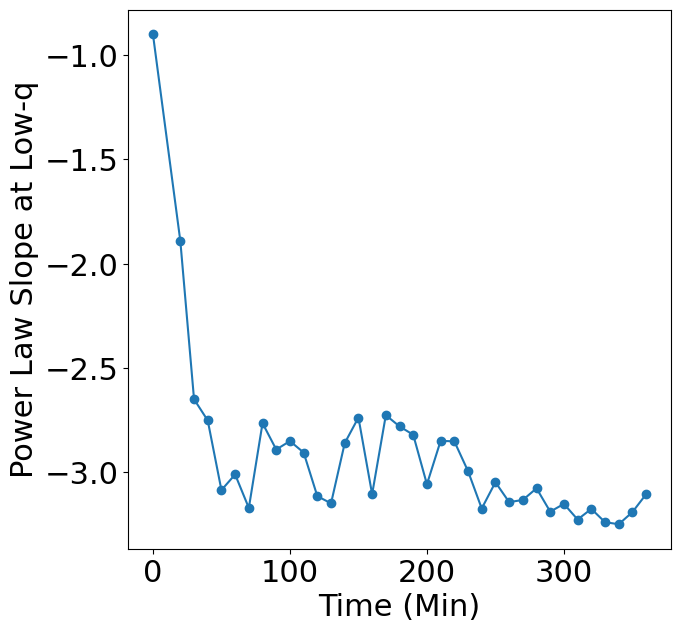

In [10]:
fig, ax = plt.subplots(figsize=(7,7))
plt.plot(times, slopes)
plt.scatter(times, slopes)
plt.xlabel('Time (Min)')
plt.ylabel('Power Law Slope at Low-q')
plt.savefig('../Figures/Kinetics_Experiment_Power_law.png', dpi=600, bbox_inches="tight")


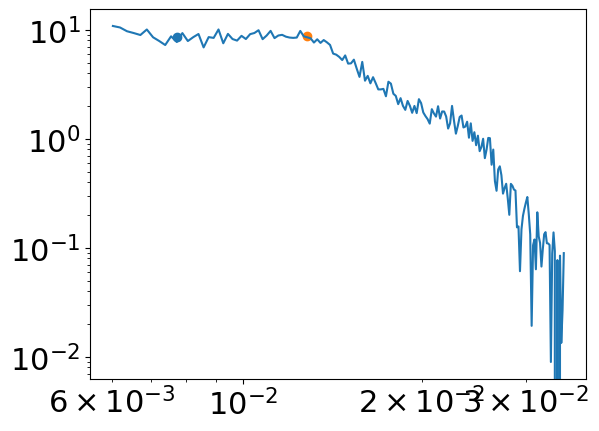

In [11]:
lower = 30
upper = 200
data = read_DAT_file(path + filenames[3])
fig, ax = plt.subplots()
plt.loglog(data[lower:upper,0], data[lower:upper,1])
plt.scatter(data[40, 0], np.mean(data[40:45, 1]))
plt.scatter(data[70, 0], np.mean(data[68:72, 1]))

In [12]:
rel_heights_ = []
for i in range(len(filenames)):
    data = read_DAT_file(path + filenames[i])
    trough = np.log10(np.mean(data[40:45, 1]))
    peak = np.log10(np.mean(data[68:72, 1]))
    peak_height = peak - trough
    if peak_height < 0:
       rel_heights_.append(0) 
    else:
        rel_heights_.append(peak_height)


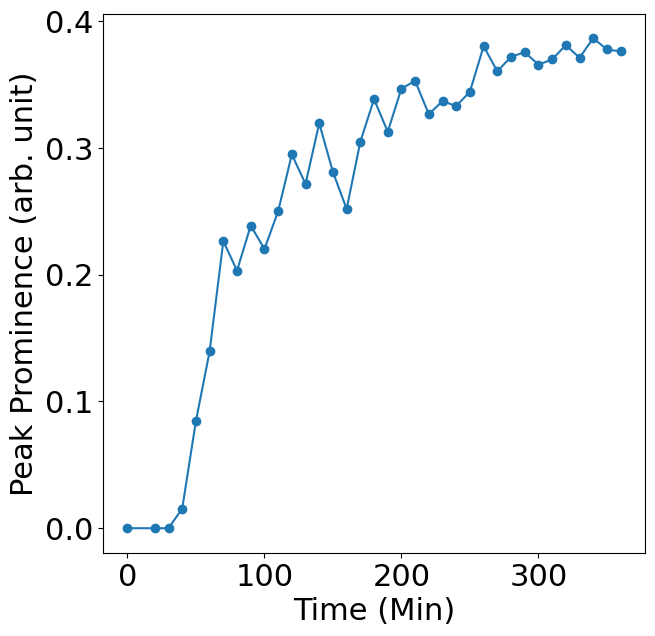

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
plt.plot(times, rel_heights_)
plt.scatter(times, rel_heights_)
plt.xlabel('Time (Min)')
plt.ylabel('Peak Prominence (arb. unit)')
#plt.savefig('../Figures/Kinetics_Experiment_Peak_Prominence.png', dpi=600, bbox_inches="tight")

In [14]:
def invariant(data):
    '''Calculates the invariant'''
    q = data[:,0]
    I = data[:,1]
    invariant = integrate.simpson(q**2*I, q)
    return invariant


In [15]:
inv_list = []
for i in range(len(filenames)):
    data = read_DAT_file(path + filenames[i])
    data = data[10:, :]
    inv = invariant(data)
    inv_list.append(inv)
inv_list = np.array(inv_list)

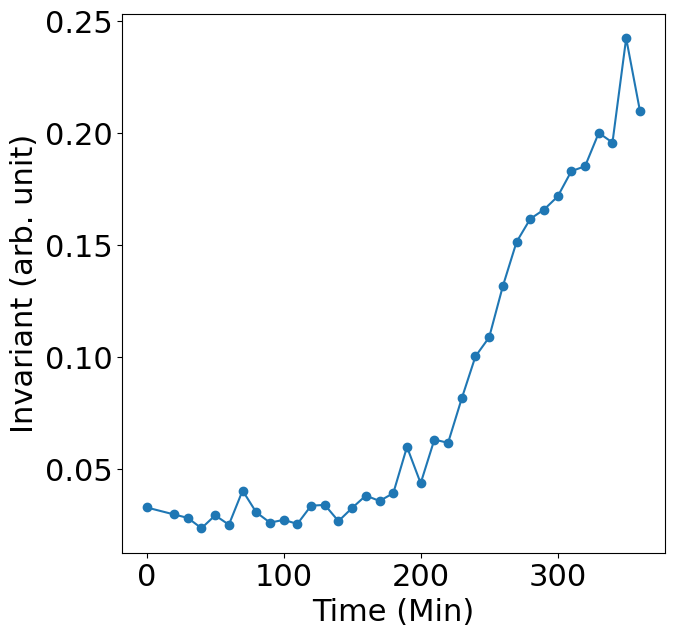

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
plt.plot(times, inv_list*1000)
plt.scatter(times, inv_list*1000)
plt.xlabel('Time (Min)')
plt.ylabel('Invariant (arb. unit)')
#plt.savefig('../Figures/Kinetics_Experiment_Invariant.png', dpi=600, bbox_inches="tight")
